# <center>Aula 3 - Analise exploratoria de dados - Solucao
## <center>Análise de doenças cardiovasculares
*Adaptado e traduzido do [ML Course](https://mlcourse.ai/)*

Nesta tarefa, você responderá a perguntas sobre um conjunto de dados sobre doenças cardiovasculares. Existem algumas tarefas que exigem que você escreva código. Conclua-as e responda às perguntas no <span style="color:blue">Google Forms</span>. 

#### Problema

Preveja a presença ou ausência de doença cardiovascular (DCV) usando os resultados do exame do paciente.

#### Descrição

Existem 3 tipos de *features* de entrada:

- *Objetivo*: informação factual;
- *Exame*: resultado de exame médico;
- *Subjetivo*: informações fornecidas pelo paciente.

| Feature | Tipo da feature | Variavel      | Tipo da variável |
|---------|--------------|---------------|------------|
| Idade | Objetivo | age | int (days) |
| Altura | Objetivo | height | int (cm) |
| Peso | Objetivo | weight | float (kg) |
| Gênero | Objetivo | gender | categorical code |
| Pressão arterial sistólica | Exame | ap_hi | int |
| Pressão sanguínea diastólica | Exame | ap_lo | int |
| Colesterol | Exame | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glicose | Exame | gluc | 1: normal, 2: above normal, 3: well above normal |
| Fumante | Subjetivo | smoke | binary |
| Ingestão alcoólica | Subjetivo | alco | binary |
| Atividade física | Subjetivo | active | binary |
| Presença ou ausência de doença cardiovascular | Target | cardio | binary |

Todos os valores do conjunto de dados foram coletados no momento do exame médico.

Vamos conhecer nossos dados realizando uma análise preliminar dos dados.

# Parte 1. Análise preliminar de dados

Primeiro, inicializaremos o ambiente:

In [ ]:
# Importando bibliotecas necessarias para a execucao do codigo
import pandas as pd
import numpy as np

# Nao vamos nos preocupar com warnings nesse exercicio,
# entao vamos desabilita-los :-)
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas de visualizacao
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Você usará a biblioteca `seaborn` para visualização de dados, então vamos configurá-la também:

In [ ]:
# Geralmente, e necessario configurar as bibliotecas de visualizacao
# antes de usa-las para garantir bons plots
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

In [ ]:
df = pd.read_csv('./heart_disease.csv')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Vamos examinar os valores das variáveis 'gender','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'.
 
Vamos converter os dados no formato *long* e descrever as contagens de valor dos recursos categóricos usando [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

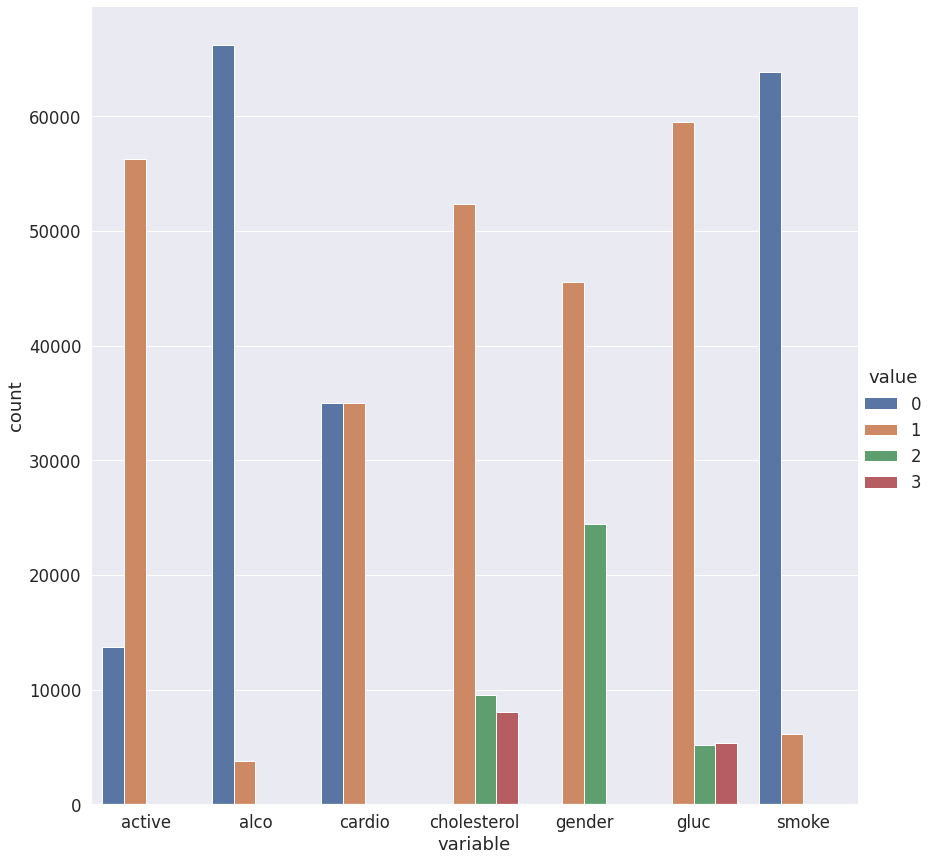

In [ ]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

Podemos ver que as classes de destino estão equilibradas. Isso é ótimo!

Vamos dividir o conjunto de dados pelos valores do *target*. Você já consegue identificar a *feature* mais discriminativa apenas olhando para o gráfico?

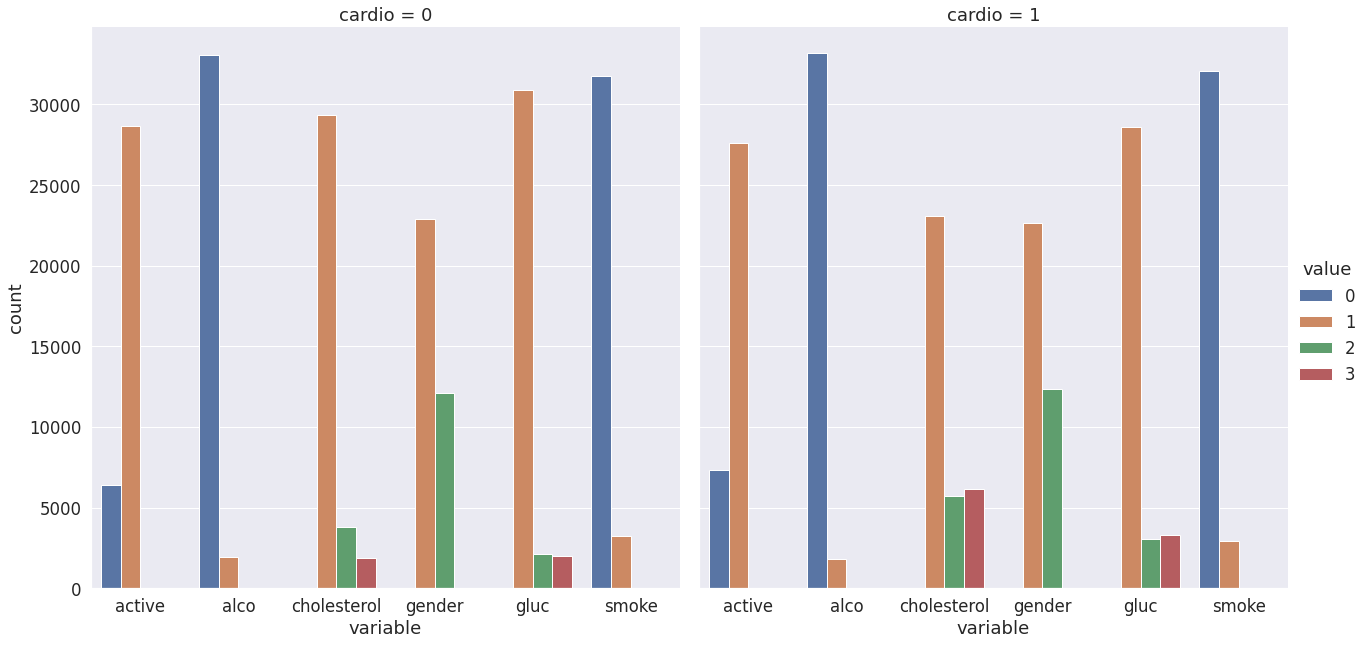

In [ ]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', size=9);

Você pode ver que a distribuição dos níveis de colesterol e glicose difere muito pelo valor do *target*. Isso é uma coincidência?

Agora, vamos calcular algumas estatísticas para os valores únicos de cada *feature*:

In [ ]:
for c in df.columns:
    n = df[c].nunique() # Numero de valores unicos por feature
    print(c)
    if n <= 3: # Se tivermos poucos valores unicos na feature, vamos exibi-los
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


No final, temos:
- 5 *features* numéricas (excluindo *id*);
- 7 *features* categóricas;
- 70000 instâncias no total.

**Importante**: Como mencionado em aula, é importante se questionar sempre dentro do processo de EDA. Dê uma olhada com calma nas *features* e verifique se você realmente consegue enxergar quais são as 5 features numéricas e as 7 features categóricas :)

## 1.1. Observações básicas

**Questão 1.1. Quantos homens e mulheres estão presentes neste conjunto de dados? Os valores da característica `gender` não foram fornecidos (se "1" significa mulheres ou homens) - descubra isso observando a altura, fazendo a suposição de que os homens são mais altos em média.**
1. 45530 mulheres e 24470 homens
2. 45530 homens e 24470 mulheres
3. 45470 mulheres e 24530 homens
4. 45470 homens e 24530 mulheres

In [ ]:
# Seu codigo aqui...

**Questão 1.2. Qual gênero relata com mais frequência o consumo de álcool - homens ou mulheres?**
1. mulheres
2. homens

In [ ]:
# Seu codigo aqui...

**Questão 1.3. Qual é a diferença entre as porcentagens de fumantes entre homens e mulheres (arredondado)?**
1. 4
2. 16
3. 20
4. 24

In [ ]:
# Seu codigo aqui...

**Questão 1.4. Qual é a diferença entre os valores das medianas de idade para fumantes e não fumantes (em meses, arredondado)? Você precisará descobrir as unidades do recurso `age` neste conjunto de dados.**

1. 5
2. 10
3. 15
4. 20

In [ ]:
# Seu codigo aqui...

## 1.2. Analisando IMC
### Task:

Crie uma nova feature – IMC ([Índice de Massa Corporal](https://en.wikipedia.org/wiki/Body_mass_index)). Para fazer isso, divida o peso em quilogramas pelo quadrado da altura em metros. Valores normais de IMC são considerados de 18,5 a 25.

In [ ]:
# Seu codigo aqui...

**Questão 1.5. Escolha as afirmações corretas:**

1. A mediana do IMC da amostra está dentro da faixa dos valores normais de IMC.
2. O IMC das mulheres é, em média, superior ao dos homens.
3. Pessoas saudáveis têm, em média, um IMC mais alto do que pessoas com DCV.
4. Para homens saudáveis que não bebem, o IMC está mais próximo da norma do que para mulheres saudáveis que não bebem

In [ ]:
# Seu codigo aqui...

## 1.3. Limpeza dos dados

### Tarefa:
Podemos ver que os dados não são perfeitos. Eles contém "sujeira" e imprecisões. Veremos isso melhor à medida que visualizamos os dados.

Filtre os seguintes segmentos de pacientes (consideramos esses dados errados)

- a pressão diastólica é maior do que a sistólica
- a altura é estritamente menor que 2,5% percentil (Use `pd.Series.quantile` para calcular este valor. Se você não estiver familiarizado com a função, leia a documentação.)
- a altura é estritamente maior que o percentil 97,5%
- o peso é estritamente inferior a 2,5% percentil
- o peso é estritamente superior a 97,5% percentil

Isso não é tudo que podemos fazer para limpar esses dados, mas isso é suficiente por enquanto.

In [ ]:
# Seu codigo aqui...

**Questão 1.6. Qual porcentagem dos dados originais (arredondados) nós jogamos fora?**

1. 8
2. 9
3. 10
4. 11

In [ ]:
# Seu codigo aqui...

# Parte 2. Análise de dados visuais

## 2.1. Visualização da matriz de correlação

Para entender melhor as features, você pode criar uma matriz de correlação entre as features. Use o dataset inicial (não filtrado) para a tarefa.

### Task:

Trace uma matriz de correlação usando [`heatmap ()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). Você pode criar a matriz usando as ferramentas padrão do `pandas` com os parâmetros default.

In [ ]:
# Seu codigo aqui...

**Questão 2.1.** Qual par de features tem a correlação de Pearson mais forte com a feature *gender*?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

## 2.2. Correlação de classificação

Na maioria dos casos, *o coeficiente de correlação linear de Pearson* é mais do que suficiente para descobrir padrões nos dados.
Mas vamos um pouco mais além e calcular uma [correlação de rank](https://en.wikipedia.org/wiki/Rank_correlation). Isso nos ajudará a identificar esses pares de features em que o rank inferior na progressão de valores de uma feature sempre precede o rank superior na outra (e temos o oposto no caso de correlação negativa).

### Task:

Calcule e plote uma matriz de correlação usando o [coeficiente de correlação de classificação de Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

In [ ]:
# Seu código

**Questão 2.2.** Por que algumas dessas features agora têm um alto coeficiente de Spearman?

1. Imprecisões nos dados (erros de aquisição de dados).
2. A relação está errada, essas *features* não devem ser relacionados.
3. Natureza monotônica, mas não necessariamente linear, dos dados.

## 2.3. Idade

Anteriormente, calculávamos a idade dos respondentes em anos no momento do exame.

### Task:

Crie um *gráfico de frequência* da feature *age_years* usando [`countplot ()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) com a idade no eixo *X* e o número de pessoas no *Eixo Y*. Seu gráfico resultante deve ter duas colunas para cada idade, correspondendo ao número de pessoas para cada classe de *cardio* daquela idade.

In [ ]:
df['age_years'] = (df['age'] / 365.25).round().astype('int')

# Seu código aqui

**Questão 2.3.** Qual é a menor idade em que o número de pessoas com DCV supera o número de pessoas sem DCV?

1. 44
2. 55
3. 64
4. 70